# 62 seq2seq

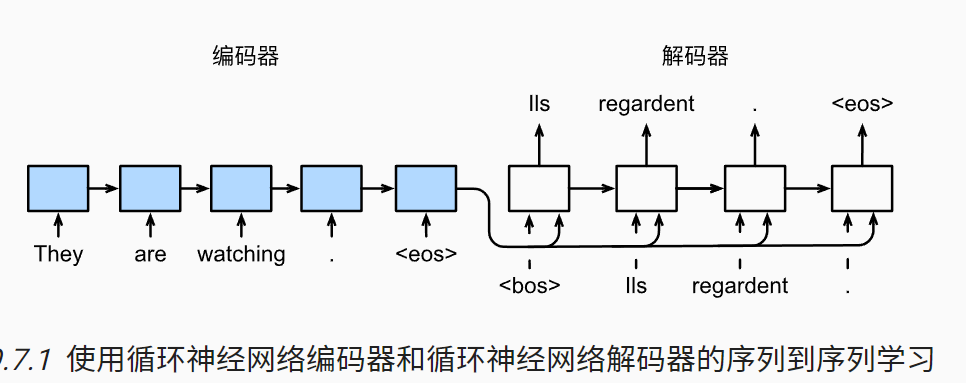

特定的“\<eos\>”表示序列结束词元。 一旦输出序列生成此词元，模型就会停止预测。 </br>
在循环神经网络解码器的初始化时间步，有两个特定的设计决定： 首先，特定的“\<bos\>”表示序列开始词元，它是解码器的输入序列的第一个词元。 其次，使用循环神经网络编码器最终的隐状态来初始化解码器的隐状态。</br>

基于“英－法”数据集来训练这个机器翻译模型

In [1]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

## 1 编码器
编码器将长度可变的输入序列转换成形状固定的上下文变量c，并且将输入序列的信息在该上下文变量中进行编码。可以使用循环神经网络来设计编码器。

现在，让我们实现循环神经网络编码器。</br>
注意，我们使用了嵌入层（embedding layer）来获得输入序列中每个词元的特征向量。 </br>
嵌入层的权重是一个矩阵，其行数等于输入词表的大小（vocab_size），其列数等于特征向量的维度（embed_size）。</br>
对于任意输入词元的索引i，嵌入层获取权重矩阵的第i行（从0开始）以返回其特征向量。 </br>
另外，本文选择了一个多层门控循环单元来实现编码器。</br>

In [2]:
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        # 创建一个嵌入层，将词汇表中的词元映射到固定维度的嵌入空间
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        # 将输入 X 通过嵌入层，将词元索引转换为词嵌入向量
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步
        # 调整张量的维度顺序，以适应循环神经网络的输入要求。将时间步的维度移动到第一个轴
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

下面，我们实例化上述编码器的实现:我们使用一个两层门控循环单元编码器，其隐藏单元数为16。给定一小批量的输入序列x(批量大小为4，时间步为7)。在完成所有时间步后，最后一层的隐状态的输出是一个张量(output由编码器的循环层返回)，其形状为(时间步数，批量大小，隐藏单元数)。


In [3]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

由于这里使用的是门控循环单元， 所以在最后一个时间步的多层隐状态的形状是 （隐藏层的数量，批量大小，隐藏单元的数量）。 如果使用长短期记忆网络，state中还将包含记忆单元信息。

In [4]:
state.shape

torch.Size([2, 4, 16])

## 2 解码器

当实现解码器时，我们直接使用编码器最后一个时间步的隐状态来初始化解码器的隐状态。这就要求使用循环神经网络实现的编码器和解码器具有相同数量的层和隐藏单元。为了进一步包含经过编码的输入序列的信息，上下文变量在所有的时间步与解码器的输入进行拼接（concatenate）。为了预测输出词元的概率分布，在循环神经网络解码器的最后一层使用全连接层来变换隐状态。

In [5]:
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # embed_size + num_hiddens，表示嵌入向量和上一时间步的隐含状态的拼接
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        # 创建一个全连接层，用于将 GRU 输出映射到词汇表大小的维度，以输出最终的预测概率分布
        self.dense = nn.Linear(num_hiddens, vocab_size)

    # 定义了初始化解码器状态的方法。这个方法接受编码器的输出 enc_outputs 作为输入，返回初始状态
    def init_state(self, enc_outputs, *args):
        # 在这个实现中，解码器的初始状态是编码器的最终隐含状态 enc_outputs[1]
        # enc_outputs里面是（outputs,state） 这里只把state拿出来
        return enc_outputs[1]

    def forward(self, X, state):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        # 把时间步提前
        X = self.embedding(X).permute(1, 0, 2)
        # 广播context，使其具有与X相同的num_steps
        # 通过重复编码器的最终隐含状态，创建一个上下文（context）张量，以匹配输入序列的长度
        # state[-1]最后时刻最后一层state的输出，重复num_steps次
        context = state[-1].repeat(X.shape[0], 1, 1)
        # 将输入序列 X 和上下文张量拼接在一起，以获得包含上下文信息的输入
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        # 把batch_size从中间换到前面
        output = self.dense(output).permute(1, 0, 2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

下面，我们用与前面提到的编码器中相同的超参数来实例化解码器。 如我们所见，解码器的输出形状变为（批量大小，时间步数，词表大小）， 其中张量的最后一个维度存储预测的词元分布。

In [6]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

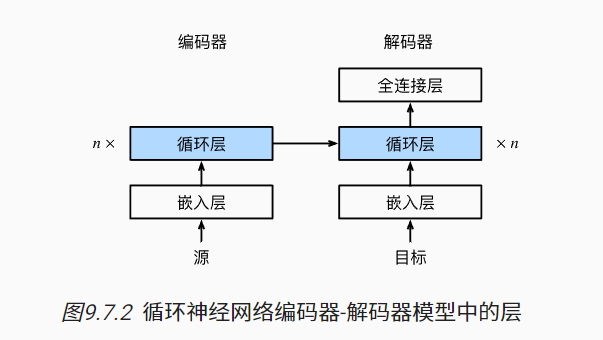

## 3 损失函数
在每个时间步，解码器预测了输出词元的概率分布。 类似于语言模型，可以使用softmax来获得分布， 并通过计算交叉熵损失函数来进行优化。 回想一下 9.5节中， 特定的填充词元被添加到序列的末尾， 因此不同长度的序列可以以相同形状的小批量加载。 但是，我们应该将填充词元的预测排除在损失函数的计算之外。
</br>
为此，我们可以使用下面的sequence_mask函数 通过零值化屏蔽不相关的项， 以便后面任何不相关预测的计算都是与零的乘积，结果都等于零。 例如，如果两个序列的有效长度（不包括填充词元）分别为1和2， 则第一个序列的第一项和第二个序列的前两项之后的剩余项将被清除为零。

In [7]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    # 创建一个掩码张量 mask，用于标记哪些位置应该保留，哪些位置应该被屏蔽。具体步骤如下：
    # torch.arange((maxlen), dtype=torch.float32, device=X.device) 创建一个张量，包含从0到maxlen-1的整数，数据类型为浮点数，设备与输入张量 X 相同。
    # [None, :] 通过添加 None 轴，将上述张量的形状从 (maxlen,) 扩展为 (1, maxlen)。
    # < valid_len[:, None] 创建一个布尔张量，其中每个位置的值表示该位置是否小于对应的有效长度，如果小于有效长度则为True，否则为False。
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    # 使用掩码张量 mask 来屏蔽输入张量 X 中不相关的项，即将对应掩码位置上的元素设为 value。
    # ~mask 表示取反，将掩码中为False的位置对应的元素设为 value。
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

我们还可以使用此函数屏蔽最后几个轴上的所有项。如果愿意，也可以使用指定的非零值来替换这些项。

In [8]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

现在，我们可以通过扩展softmax交叉熵损失函数来遮蔽不相关的预测。 最初，所有预测词元的掩码都设置为1。 一旦给定了有效长度，与填充词元对应的掩码将被设置为0。 最后，将所有词元的损失乘以掩码，以过滤掉损失中填充词元产生的不相关预测。

In [9]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        # pytorch要求把预测维度放中间
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        # 有效的维度留下了 无效的变成零
        # mean(dim=1)对每个句子取平均 返回样本的loss
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

我们可以创建三个相同的序列来进行代码健全性检查，然后分别指定这些序列的有效长度为4、2和0。结果就是，第一个序列的损失应为第二个序列的两倍，而第三个序列的损失应为零。


In [10]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

## 4 训练

在下面的循环训练过程中，特定的序列开始词元（“\<bos\>”）和 原始的输出序列（不包括序列结束词元“\<eos\>”） 拼接在一起作为解码器的输入。 这被称为强制教学（teacher forcing），因为原始的输出序列（词元的标签）被送入解码器。或者，将来自上一个时间步的预测得到的词元作为解码器的当前输入。
训练时解码器使用目标句子作为输入。

In [11]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                     xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            # 对于原句子的Y 去掉最后一行 在第一行加入<bos>
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                          device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()      # 损失函数的标量进行“反向传播”
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

现在，在机器翻译数据集上，我们可以 创建和训练一个循环神经网络“编码器－解码器”模型用于序列到序列的学习。

loss 0.019, 23622.7 tokens/sec on cuda:0


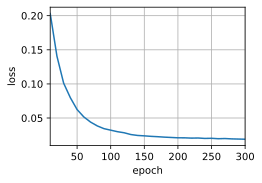

In [12]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## 5 预测
为了采用一个接着一个词元的方式预测输出序列，每个解码器当前时间步的输入都将来自于前一时间步的预测词元。与训练类似，序列开始词元（“\<bos\>”）在初始时间步被输入到解码器中。当输出序列的预测遇到序列结束词元（“\<eos\>”）时，预测就结束了。
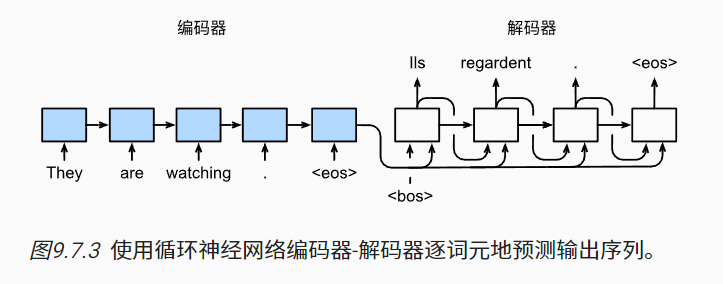

In [13]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    # 创建一个包含有效长度信息的张量 enc_valid_len，该张量的值是源语言句子的长度。
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    # 将源语言句子转换为长度为 num_steps 的张量，同时进行截断或填充操作。
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    # unsqueeze升维
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        # squeeze降维 去掉batchsize维
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

# 6 预测序列的评估
BLEU（bilingual evaluation understudy） 最先是用于评估机器翻译的结果，但现在它已经被广泛用于测量许多应用的输出序列的质量。原则上说，对于预测序列中的任意n元语法（n-grams），BLEU的评估都是这个n元语法是否出现在标签序列中。</br>
简单来说就是产生的预测串中的长度为n子串在标签中的出现率</br>
惩罚过短预测，长匹配有高权重
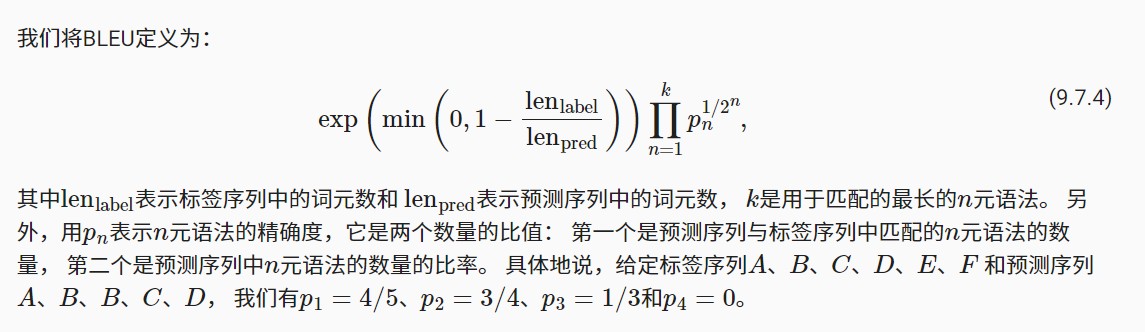

In [14]:
def bleu(pred_seq, label_seq, k):  #@save
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

最后，利用训练好的循环神经网络“编码器－解码器”模型， 将几个英语句子翻译成法语，并计算BLEU的最终结果。

In [15]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est paresseux ?, bleu 0.537
i'm home . => je suis gras ., bleu 0.512


#### 根据"编码器-解码器"架构的设计，我们可以使用两个循环神经网络来设计一个序列到序列学习的模型。
#### 在实现编码器和解码器时，我们可以使用多层循环神经网络。
#### 我们可以使用遮蔽来过滤不相关的计算，例如在计算损失时。
#### 在"编码器一解码器"训练中，强制教学方法将原始输出序列(而非预测结果）输入解码器。
#### BLEU是一种常用的评估方法，它通过测量预测序列和标签序列之间的n元语法的匹配度来评估预测。

In [21]:
ppp=torch.unsqueeze(torch.tensor([[4,3,2],[1,2,3]]), dim=1)

In [22]:
ppp

tensor([[[4, 3, 2]],

        [[1, 2, 3]]])